In [10]:
# import the necessary packages

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.layers import Input, AveragePooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
from keras import regularizers
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
#import cv2

In [2]:
# Load data: images and labels

data = []
labels = []

In [3]:
data1 = np.array(np.load("../data/all_images_kimeye.npy"))
labels1 = np.array(np.load("../data/all_labels_kimeye.npy"))
labels1 = labels1.astype(int)

In [4]:
data2 = np.array(np.load("../data/all_images_acrima.npy"))
labels2 = np.array(np.load("../data/all_labels_acrima.npy"))
labels2 = labels2.astype(int)

In [5]:
data = np.concatenate((data1, data2), axis=0)
labels = np.concatenate((labels1, labels2), axis=0)

print(data.shape)
print(labels[0])

(2249, 224, 224, 3)
0


In [6]:
# shuffle the whole dataset

shuffle = list(zip(data, labels))
np.random.seed(42)
np.random.shuffle(shuffle)
data = np.array([shuffle[i][0] for i in range(len(shuffle))])
labels = np.array([shuffle[i][1] for i in range(len(shuffle))])
del shuffle


In [11]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = np_utils.to_categorical(labels)

data = np.array(data)
print(labels)
#labels = np.array(labels)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [0]:
"""
plt.imshow(data[254])
plt.show()
print(labels[254])

plt.imshow(data[1])
plt.show()
print(labels[1])
"""

'\nplt.imshow(data[254])\nplt.show()\nprint(labels[254])\n\nplt.imshow(data[1])\nplt.show()\nprint(labels[1])\n'

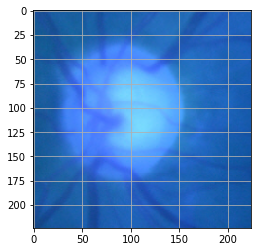

[1. 0.]


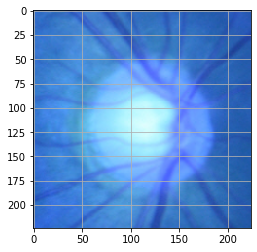

[0. 1.]


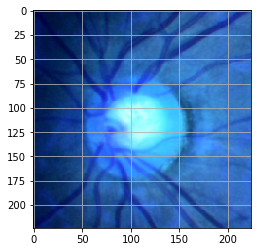

[0. 1.]


In [12]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
	test_size=0.25, random_state=42)

plt.grid(None)

plt.imshow(trainX[10])
plt.show()
print(trainY[10])

plt.grid(None)

plt.imshow(testX[276])
plt.show()
print(testY[276])

plt.grid(None)

plt.imshow(testX[208])
plt.show()
print(testY[208])

In [13]:
# initialize the training data augmentation object

trainAug = ImageDataGenerator(
	rotation_range=40,
	zoom_range=0.2,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.2,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
#mean = np.array([123.68, 116.779, 103.939], dtype="float32")
#trainAug.mean = mean
#valAug.mean = mean

Labels: [array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32)]


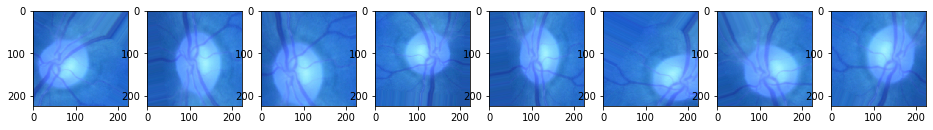

In [14]:
# visualize the different geometric transformations operated to the images

img_id = 600
cat_generator = trainAug.flow(trainX[img_id:img_id+1], 
 trainY[img_id:img_id+1], 
 batch_size=1) 
cat = [next(cat_generator) for i in range(0,8)] 
fig, ax = plt.subplots(1,8, figsize=(16, 6))

print('Labels:', [item[1][0] for item in cat]) 
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,8)]

In [15]:
# load InceptionV3, ensuring the head FC layer sets are left off, while at
# the same time adjusting the size of the input image tensor to the
# network
baseModel = InceptionV3(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

87916544/87910968 [==============================] - 14s 0us/step


In [16]:
# show a summary of the base model
print("[INFO] summary for base model...")
print(baseModel.summary())

[INFO] summary for base model...
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
______________________________________________________

In [17]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.layers[-63].output
#headModel = Flatten(name="flatten")(headModel)
#headModel = Dropout(0.5)(headModel)
#headModel = Dense(256, activation="relu")(headModel)

headModel = GlobalAveragePooling2D()(headModel)
# let's add a fully-connected layer
headModel = Dense(256, activation='relu')(headModel)
#headModel = Dropout(0.5)(headModel)
#headModel = Dense(128, activation='relu')(headModel)
#headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
 
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [18]:
print(len(baseModel.layers))

311


In [19]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
   layer.trainable = False

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [21]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
#opt = Adam(lr=1e-4)
#opt = RMSprop(lr=1e-4)
opt = SGD(lr=1e-4, momentum=0.9)
#opt = Adagrad(lr=1e-4, decay=1e-6)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [22]:
epochs = 100
batch_size = 32

# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=epochs)

[INFO] training head...
Epoch 1/100
52/52 [==============================] - 25s 490ms/step - loss: 0.7356 - accuracy: 0.4976 - val_loss: 0.6761 - val_accuracy: 0.5239
Epoch 2/100
52/52 [==============================] - 20s 383ms/step - loss: 0.6896 - accuracy: 0.5224 - val_loss: 0.7018 - val_accuracy: 0.5217
Epoch 3/100
52/52 [==============================] - 19s 372ms/step - loss: 0.6783 - accuracy: 0.5659 - val_loss: 0.6763 - val_accuracy: 0.5556
Epoch 4/100
52/52 [==============================] - 19s 368ms/step - loss: 0.6643 - accuracy: 0.6282 - val_loss: 0.6558 - val_accuracy: 0.5838
Epoch 5/100
52/52 [==============================] - 19s 370ms/step - loss: 0.6555 - accuracy: 0.6554 - val_loss: 0.6980 - val_accuracy: 0.5744
Epoch 6/100
52/52 [==============================] - 19s 366ms/step - loss: 0.6499 - accuracy: 0.6524 - val_loss: 0.6518 - val_accuracy: 0.6215
Epoch 7/100
52/52 [==============================] - 19s 365ms/step - loss: 0.6393 - accuracy: 0.6880 - val_loss

52/52 [==============================] - 19s 366ms/step - loss: 0.4744 - accuracy: 0.7890 - val_loss: 0.6883 - val_accuracy: 0.6215
Epoch 58/100
52/52 [==============================] - 19s 364ms/step - loss: 0.4661 - accuracy: 0.8102 - val_loss: 0.6541 - val_accuracy: 0.6215
Epoch 59/100
52/52 [==============================] - 19s 368ms/step - loss: 0.4732 - accuracy: 0.7867 - val_loss: 0.6973 - val_accuracy: 0.6083
Epoch 60/100
52/52 [==============================] - 19s 362ms/step - loss: 0.4779 - accuracy: 0.7792 - val_loss: 0.6575 - val_accuracy: 0.6309
Epoch 61/100
52/52 [==============================] - 19s 367ms/step - loss: 0.4635 - accuracy: 0.7932 - val_loss: 0.5926 - val_accuracy: 0.6478
Epoch 62/100
52/52 [==============================] - 19s 369ms/step - loss: 0.4762 - accuracy: 0.7914 - val_loss: 0.5607 - val_accuracy: 0.5744
Epoch 63/100
52/52 [==============================] - 19s 367ms/step - loss: 0.4877 - accuracy: 0.7703 - val_loss: 0.6176 - val_accuracy: 0.647

In [23]:
# evaluate the network

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1)))


[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.98      0.18      0.30       277
           1       0.56      1.00      0.71       286

    accuracy                           0.59       563
   macro avg       0.77      0.59      0.51       563
weighted avg       0.76      0.59      0.51       563



In [0]:
score = model.evaluate(testX, testY,batch_size=32, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5739732858739368
Test accuracy: 0.7227979274611399


In [0]:
# evaluate the network
"""
repository = 'drive/My Drive/dataset/Test/glaucomatous/drishtiGS_001.png'
repository2 = 'drive/My Drive/dataset/Training/healthy/drishtiGS_008.png'
repository3 = 'drive/My Drive/17.png'
repository4 = 'drive/My Drive/5.png'

test_image = cv2.imread(repository3)
plt.imshow(test_image)

test_image = test_image/255
test_image = np.resize(test_image, (224,224,3))
test_image = np.expand_dims(test_image, axis=0)
print(test_image.shape)


pred = model.predict(test_image) # ADD CODE HERE
print(pred)
#print(preds)
label = np.argmax(pred) # ADD CODE HERE
print(label)
"""

"\nrepository = 'drive/My Drive/dataset/Test/glaucomatous/drishtiGS_001.png'\nrepository2 = 'drive/My Drive/dataset/Training/healthy/drishtiGS_008.png'\nrepository3 = 'drive/My Drive/17.png'\nrepository4 = 'drive/My Drive/5.png'\n\ntest_image = cv2.imread(repository3)\nplt.imshow(test_image)\n\ntest_image = test_image/255\ntest_image = np.resize(test_image, (224,224,3))\ntest_image = np.expand_dims(test_image, axis=0)\nprint(test_image.shape)\n\n\npred = model.predict(test_image) # ADD CODE HERE\nprint(pred)\n#print(preds)\nlabel = np.argmax(pred) # ADD CODE HERE\nprint(label)\n"

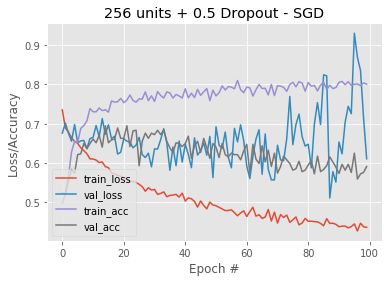

In [28]:
# plot the training loss and accuracy

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("256 units + 0.5 Dropout - SGD")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [0]:
plt.savefig('drive/My Drive/inceptionv3_warm_up_performance.png')
#model.save("drive/My Drive/inceptionv3_warm_up_model.h5")

<Figure size 432x288 with 0 Axes>

In [0]:
# initialize the training data augmentation object

trainAug2 = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug2 = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
#mean = np.array([123.68, 116.779, 103.939], dtype="float32")
#trainAug2.mean = mean
#valAug2.mean = mean


In [0]:
"""
trainAug2 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset   
        samplewise_center=False,  # set each sample mean to 0   
        featurewise_std_normalization=False,  # divide inputs by std of the dataset   
        samplewise_std_normalization=False,  # divide each input by its std  
        zca_whitening=False,  # apply ZCA whitening     
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)  <<1    0 => 30
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.2,  # set range for random shear  <<3<<4  0 => 0.1 => 0.2
        zoom_range=0.3,  # set range for random zoom    <<1<<2<<3   0 => 0.1 => 0.2 =>0.3 
        channel_shift_range=0.2,  # set range for random channel shifts     <<5<<6   0.=>0.1=>0.2
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"     
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images    <<1    false => True
        # set rescaling factor (applied before any other transformation)
        rescale=None,   
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
"""

'\ntrainAug2 = ImageDataGenerator(\n        featurewise_center=False,  # set input mean to 0 over the dataset   \n        samplewise_center=False,  # set each sample mean to 0   \n        featurewise_std_normalization=False,  # divide inputs by std of the dataset   \n        samplewise_std_normalization=False,  # divide each input by its std  \n        zca_whitening=False,  # apply ZCA whitening     \n        zca_epsilon=1e-06,  # epsilon for ZCA whitening\n        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)  <<1    0 => 30\n        # randomly shift images horizontally (fraction of total width)\n        width_shift_range=0.1,\n        # randomly shift images vertically (fraction of total height)\n        height_shift_range=0.1,\n        shear_range=0.2,  # set range for random shear  <<3<<4  0 => 0.1 => 0.2\n        zoom_range=0.3,  # set range for random zoom    <<1<<2<<3   0 => 0.1 => 0.2 =>0.3 \n        channel_shift_range=0.2,  # set range for rand

In [0]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(baseModel.layers):
   #print(i, layer.name)

In [0]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [0]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 111, 111, 32) 96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 111, 111, 32) 0           batch_normalization_283[0][0]    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
#for layer in baseModel.layers[30:]:
	#layer.trainable = True

In [0]:
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [0]:
epochs = 150

# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training network...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, shuffle=True, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=epochs)


[INFO] training network...
Epoch 1/150
36/36 [==============================] - 40s 1s/step - loss: 0.5006 - acc: 0.7618 - val_loss: 0.6260 - val_acc: 0.6745
Epoch 2/150
36/36 [==============================] - 26s 733ms/step - loss: 0.5035 - acc: 0.7682 - val_loss: 0.6412 - val_acc: 0.6667
Epoch 3/150
36/36 [==============================] - 27s 752ms/step - loss: 0.4946 - acc: 0.7707 - val_loss: 0.6568 - val_acc: 0.6525
Epoch 4/150
36/36 [==============================] - 27s 741ms/step - loss: 0.4703 - acc: 0.7818 - val_loss: 0.6335 - val_acc: 0.6695
Epoch 5/150
36/36 [==============================] - 27s 740ms/step - loss: 0.4607 - acc: 0.7802 - val_loss: 0.5638 - val_acc: 0.7232
Epoch 6/150
36/36 [==============================] - 27s 755ms/step - loss: 0.4921 - acc: 0.7708 - val_loss: 0.6574 - val_acc: 0.6525
Epoch 7/150
36/36 [==============================] - 26s 727ms/step - loss: 0.4385 - acc: 0.7987 - val_loss: 0.6106 - val_acc: 0.7062
Epoch 8/150
36/36 [===================

In [0]:
# plot the training loss and accuracy

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [0]:
plt.savefig('drive/My Drive/vgg16_fine_tuned_performance.png')
model.save("drive/My Drive/vgg16_fine_tuned_model_0.h5")

In [0]:
score = model.evaluate(testX, testY,batch_size=32, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
repository = 'drive/My Drive/17.png'
repository2 = 'drive/My Drive/5.png'
repository3 = 'drive/My Drive/dataset/Test/glaucomatous/drishtiGS_001.png'
repository4 = 'drive/My Drive/dataset/Training/healthy/drishtiGS_008.png'

test_image = cv2.imread(repository4)
plt.imshow(test_image)

test_image = test_image/255
test_image = np.resize(test_image, (224,224,3))
test_image = np.expand_dims(test_image, axis=0)
print(test_image.shape)


pred = model.predict(test_image) # ADD CODE HERE
print(pred)
#print(preds)
label = np.argmax(pred) # ADD CODE HERE
print(label)
